# Notebook example of genetic algorithms for optimization problems 
In this notebook we are using the deap framework for the usecase of the Schaffer function as a general optimization problem.

## 1. The Schaffer N. 1 multi-objective function
The Schaffer N. 1 multi-objective function is a testfunction for optimization problems, which consists of two simple functions. It takes into account only x and as the two functions span a curve, it can be used to create a nice plot for visualization of the optimization steps. The two functions building the Schaffer function are:
- f1(x) = x <sup>2</sup>
- f2(x) = (x - 2) <sup>2</sup>

In [1]:
# Imports
import numpy as np

# Minimum and maximum of x1, x2 values
X_RANGE = (-1000, 1000)

# Schaffer functions
def schaffer_f1(x):
    return x ** 2

def schaffer_f2(x):
    return (x - 2) ** 2

# Schaffer evaluation function, which runs both individual functions and returns their values as tuple (which have to be minimized)
def schaffer_eval(individual):
    return schaffer_f1(*individual), schaffer_f2(*individual)

# Function for creation of individual
# One random value [0, 1] is taken and projected on the range of limits as given in the parameter x_range
def make_individual(x_range):
    return list(np.random.random(1) * np.abs(np.diff(x_range)) + np.min(x_range))

# Vectorize the functions so that they can take arrays as arguments; used for plotting reasons where a bigger set of x1, x2 values has to calculated to y values
schaffer_f1_vec = np.vectorize(schaffer_f1)
schaffer_f2_vec = np.vectorize(schaffer_f2)

## 2. Creating a plot of the Schaffer N. 1 multi-objective function
The plot is created for a three-dimensional body retsulting from ackley(a, b, c, x1, x2). x1 and x2 are limited to a range of -40 to 40 with steps 1. The parameters are set to a = 20, b = 0.2, c = 2*pi .

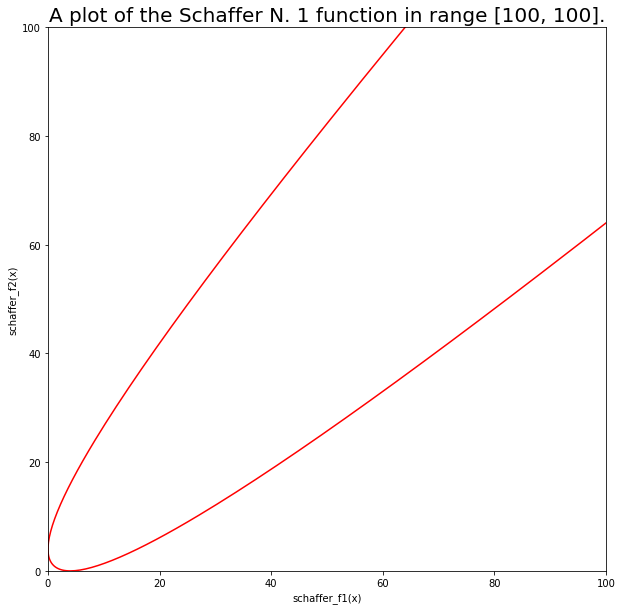

In [2]:
# Imports
import matplotlib.pyplot as plt
%matplotlib inline
# from matplotlib import cm
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# from mpl_toolkits import mplot3d
import numpy as np

# Range for created plot (reasonable values so that the user can see changes!)
PLOT_RANGE = [100, 100]

# Range of values used for x1, x2
x_vals = np.arange(X_RANGE[0], X_RANGE[1] + 1, 0.1)

# Create a new figure
fig = plt.figure(figsize=(10, 10))

# Adding a title
plt.title("A plot of the Schaffer N. 1 function in range {}.".format(str(PLOT_RANGE)), fontdict = {"fontsize": 20})

# Scatter plot over x1, x2 and y values with colors as defined before
plt.plot(schaffer_f1_vec(x_vals), schaffer_f2_vec(x_vals), c="red")
plt.xlabel("schaffer_f1(x)")
plt.ylabel("schaffer_f2(x)")

# Set limits
plt.xlim((0, PLOT_RANGE[0]))
plt.ylim((0, PLOT_RANGE[1]))

# Show
plt.show()

## 3. Setting up the deap toolbox for genetic algorithms
The deap library (https://github.com/DEAP/deap, https://deap.readthedocs.io/en/master/) is a framework that offers everything one needs to simply setup a genetic algorithm concept. Therefor it provides the user with a set of initilization-, crossover-, mutation- as well as selection-functions that include proven methods. The way deap works makes it very easy to setup a run-ready system.

The following code initiates a deap framework with the following objectives:
- having a multi-objective optimization looking for minimization 
    * weights is a tuple with two values (weights = (-1, -1))
    * negative for minimization!
- creating a population of individuals which all have a random integers in a given range which stands for a reasonible limit for the function where function values behind those limits do not change relevant anymore
- giving an evaluation function which shall be optimized by the genetic algorithm (here: defined schaffer_eval)
    * the function is rewritten as ackley_eval where the only argument is the individual
    * inside there's one call of the ackley function with the above defined a, b, c parameters and the individual which is used for the given dimensions
- giving the function for mating which is chosen to be simulated binary bounded
    * this simulates a binary mating
    * in binary mating binary-coded values are used instead of real-coded ones
    * simulated binary crossover intends to replace this function by using distribution functions on which the real-coded values are crossed 
- giving the function for mutation which is chosen to be polynomial bounded
    * polynomial bounded mutation intends to create a mutation based on a polynomial probability function
    * values are limited by their bounds
- giving the function for selection which is here chosen as selNSGA2
    * selNSGA2 does a selection based on multiobjective optimization
    
It follows the article of Deb, 2002 [https://pdfs.semanticscholar.org/dc4e/c99d4201affa93f404c6b4e4f8538d07aeb5.pdf], who have developed the NSGA-2 algorithm and also have shown some composition of optimization solving by combining simulated binary bound crossover and polynomial bound mutation.
    
The mutation parameters given are:
- ETA
    * set to be 20
    * a parameter that defines how similiar children should be to their parents (could be called crowding distance)
    * Deb chose this value size without further explanation and it's still unclear what value exactely to choose
- LOW
    * set to be -1000
    * lower bound of our value
    * through mating and mutation values can't go lower then this value!
- UP
    * set to be 1000
    * upper bound of our value
    * through mating and mutation values can't go higher then this value!
- INDPB
    * set to be 0.05
    * independent probability value which is taken as gate to choose if mutation will happen or not
    * another check after MUTPB
- CXPB
    * set to be 0.5
    * crossing probability for which a random value has to be lower to make crossing happen
- MUTPB
    * set to be 0.2
    * mutation probability for which a random value has to be lower to make mutation happen

In [3]:
# Parameters for genetic algorithms
ETA = 20
LOW = X_RANGE[0]
UP = X_RANGE[1]
INDPB = 0.05
CXPB = 0.5 
MUTPB = 0.2

# Import of deap modules
from deap import base, creator, tools, algorithms

# Module base is used to create a container for the individuals that holds the fitness function as well as later added parameters (here: pair of x1, x2)
# First FitnessMin class is registered with weights according to optimization objective
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# Second the Individual class having a list container with parameters and a fitness value is created
creator.create("Individual", list, fitness=creator.FitnessMin)

# Now toolbox with genetic algorithm functions is created
toolbox = base.Toolbox()
# Candidate (container for individual) is added with function make_individual that creates a pair of x1, x2 values; function is called with limits of x1, x2 respectively
toolbox.register("candidate", make_individual, X_RANGE)
# Individuals are created by calling the candidate function which again calls the make_individual function
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.candidate)
# Population is created putting a number of individuals in a list
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Evaulate function is set as ackley_eval as defined before
toolbox.register("evaluate", schaffer_eval)

# Function for mating is set to be simulated binary bounded (means parameters can't leave the given range of bounds)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=ETA, low=LOW, up=UP)
# Function for mutatiion is set to be polynomial bounded and again parameters can#t leave their bounds
toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA, low=LOW, up=UP, indpb=INDPB)
# toolbox.register("select", tools.selNSGA2)
# Selection is set to be selBest which simply picks k best individuals of population to be the new generation population start
toolbox.register("select", tools.selNSGA2)

C:\Users\benjamin\Anaconda3\envs\inowas\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


For further explanation we will again take a look at the NSGA2 algorithm. NSGA2 stands for non sorting genetic algorithm in its second version as created by Deb, 2002 [https://pdfs.semanticscholar.org/dc4e/c99d4201affa93f404c6b4e4f8538d07aeb5.pdf]. The paradigm of this algorithm is that
    
* a non dominated solution (which is seen as a better solution) has to be no worse for any of it's parameters
* should be better for at least one of its parameters 

This kind of solution symbolizes a pareto front of optimal solutions.

More on that here: [http://oklahomaanalytics.com/data-science-techniques/nsga-ii-explained/]

## 4. Running the genetic algorithm on a population
Now that the framework is set up, we can run the algorithm. To map the progress on graphs, we'll have to generate some steps and for each step a certain amount of generations is run through and afterwards the current best solutions are saved. Thus after the whole process each steps best solutions can be plotted and an animation can be created.

The algorithm which is used here is easimple which runs a simple evolution algorithm and when it comes to mating and mutation, combines both so that in one generation an individual could mate itself as well as mutate.

In [4]:
# Import deepcopy
from copy import deepcopy

# Population size
POP_SIZE = 50
# Generations per step
GEN_PER_STEP = 5
# Number of steps
GEN_STEPS = 100
# Popultion is build with size
pop = toolbox.population(n=POP_SIZE)
# Hall of fame is build as a pareto front (because of multi-objective optimization!)
hall_of_fame = tools.ParetoFront()

# Empty array for best individuals of every step is created
best_of_step = []

# For loop through steps
for step in range(GEN_STEPS):
    # Simple evolution applied; feedback returned to hall of fame; population is returned to overwrite success
    pop, _ = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, GEN_PER_STEP, halloffame=hall_of_fame, verbose=False)
    # Current hall of fame is copied and appended to best of
    best_of_step.append(list(deepcopy(hall_of_fame)))

## 5. Ceating some comparison plots of the genetic algorithm
In order to show the effectivity of the genetic algorithm, its progress is plotted for different steps (beginning, mid, end). Thus one should recognize how solutions are moving towards the optimal solution (or not, if the algorithm fails). 

Hint: The optimal solution lays between x \[0, 2]. This area is surrounded with a green square!

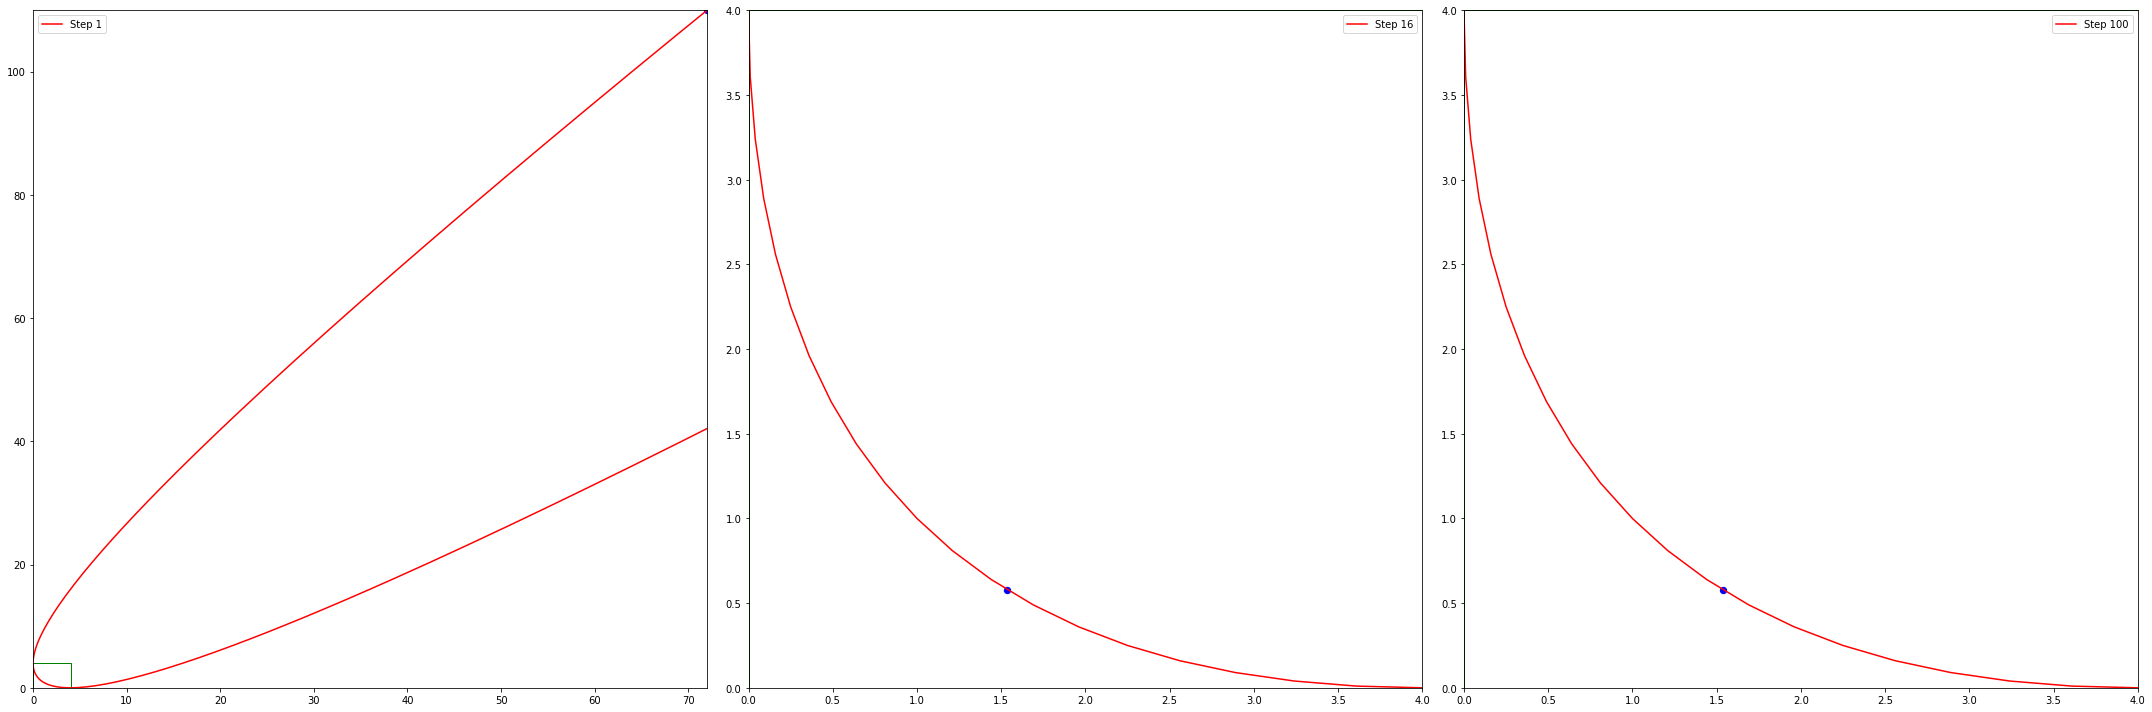

In [5]:
from matplotlib.patches import Rectangle

SCHAFFER_OPT = [0, 2]

# Create an empty figure, this time broader for space of three plots!
f = plt.figure(figsize=(30, 10))

# Add three subplots for the different states
ax1 = f.add_subplot(1, 3, 1)
ax2 = f.add_subplot(1, 3, 2)
ax3 = f.add_subplot(1, 3, 3)

# Give indizes of which solutions are picked
INDIZES = [0, 15, 99]

# Loop through indizes combined with axes of subplots to create the graphs
for ax, ind in zip([ax1, ax2, ax3], INDIZES):
    # Calculating function values
    f1_values = schaffer_f1_vec(best_of_step[ind])
    f2_values = schaffer_f2_vec(best_of_step[ind])
    
    # Create a general plot of the function
    ax.plot(schaffer_f1_vec(x_vals), schaffer_f2_vec(x_vals), c="red", label="Step {}".format(str(ind + 1)))
    
    # Create scatters of the hall of fame solutions
    ax.scatter(f1_values, f2_values, c="blue", s=40)
    
    # Set plot limits
    ax.set_xlim((0, max(max(schaffer_f1_vec(SCHAFFER_OPT)), max(f1_values))))
    ax.set_ylim((0, max(max(schaffer_f2_vec(SCHAFFER_OPT)), max(f2_values))))
    
    # Create rectangle
    rect = Rectangle((0, 0), max(schaffer_f1_vec(SCHAFFER_OPT)), max(schaffer_f2_vec(SCHAFFER_OPT)), edgecolor="g", facecolor="none")
    # Adding to plot
    ax.add_patch(rect)
            
    ax.legend()
    
plt.tight_layout()
plt.show()

## 6. Running linear optimization on the output of the genetic algorithm
After having run the genetic algorithm, the generated solutions are limited to the crossover and mutation functions as a method of improvement. However, there's another chance of improving the solution by taking a look at it with linear optimization. Here we will use the Nelder-Mead algorithm from Nelder and Mead (1965).

The Nelder-Mead algorithm is used for non-linear optimization so that the locally found solution can be set to the local optimum. This is done by spanning a simplex (convex hull), which then can be modified by either mirroring, expanding, contracting or compressing in order to reach the local optimum point.

In order to run the linear optimization first we have to simplify our evaluation function to a scalar, which means it should only return one single objective value

In [6]:
# Imports
# Import of solvers NelderMeadSimplex
from mystic.solvers import NelderMeadSimplexSolver
# Import of the termination criteria which here is CRT, that is based on relative difference between candidates for termination
from mystic.termination import CandidateRelativeTolerance as CRT

# Schaffer evaluation function is again simplified by reducing the solution to a scalar of a sum of both function returns
def schaffer_scalar(individual):
    return sum(schaffer_eval(individual))

# Give dimension size for solver (this spans the simplex)
DIM_SIZE = 1

# Set initial point to be the best solution of the previously generated solutions by the genetic algorithm
best_gen = hall_of_fame[0]

# Create model with schaffer function as evaluation
# schaffer_model = AbstractModel(name="schaffer", metric=schaffer_eval)
# schaffer_model.evaluate(

# Initiate solver with class NelderMeadSimplexSolver and dimension size as argument
solver = NelderMeadSimplexSolver(DIM_SIZE)

# # Initial point is best solution
solver.SetInitialPoints(best_gen)
# # solver.SetEvaluationMonitor(evalmon)
# # solver.SetGenerationMonitor(stepmon)
# # solver.enable_signal_handlseer()
# # Termination criteria is set to be CRT
solver.SetTermination(CRT())

# # Function to solve is schaffer_eval
solver.Solve(schaffer_scalar)

# obtain the solution
best_gen_opt = solver.Solution()

## 7. Creating a comparison graph for the best generated solution and the linear optimized solution

Now that the best solution as given by the genetic algorithm has been linaer optimized we want to conclude with a comparison of both values and see what has changed through this last step. To do so we'll create a graph with both points in it.

(0, 4)

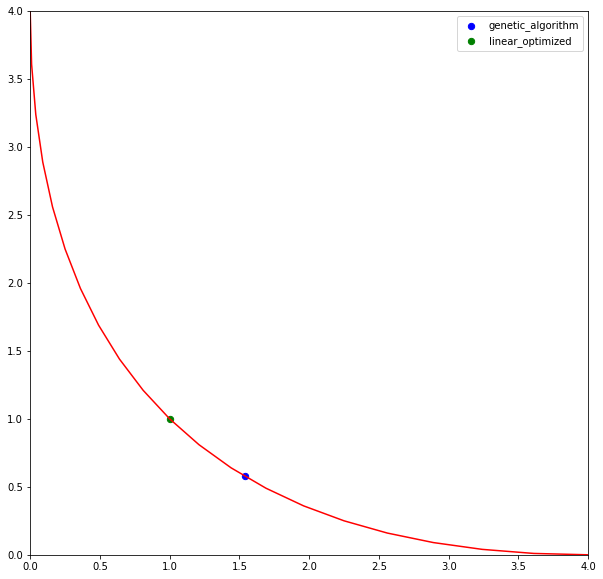

In [7]:
# Create an empty figure, this time broader for space of three plots!
f = plt.figure(figsize=(10, 10))

# Create a general plot of the function
plt.plot(schaffer_f1_vec(x_vals), schaffer_f2_vec(x_vals), c="red")

# Create scatters of the hall of fame solutions
plt.scatter(schaffer_f1_vec(best_gen), schaffer_f2_vec(best_gen), c="blue", label="genetic_algorithm", s=40)
plt.scatter(schaffer_f1_vec(best_gen_opt), schaffer_f2_vec(best_gen_opt), c="green", label="linear_optimized", s=40)

# Add legend
plt.legend()

# Limit the plot to box
plt.xlim((0, max(schaffer_f1_vec(SCHAFFER_OPT))))
plt.ylim((0, max(schaffer_f2_vec(SCHAFFER_OPT))))

As can be seen in the plot the algorithm has moved the solution towards the point in (1, 1), which in this case is the best solution we can get. This way the linear optimization was successfull.